In [1]:
from utils import load_chars_dataset, show_image, load_detection_images, get_label
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from skimage import feature

In [2]:
X, y, images = load_chars_dataset()

(14224, 900) (900,)


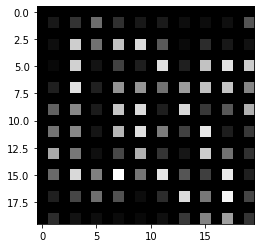

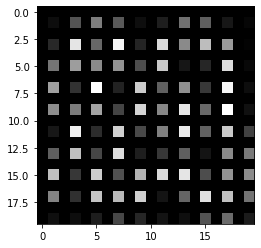

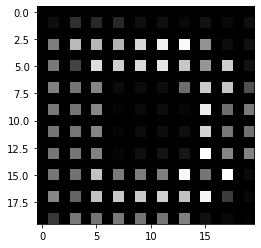

a a d


In [3]:
#i print some images

print(X.shape, X[0].shape)

plt.imshow(images[0], cmap="gray")
plt.show()
plt.imshow(images[800], cmap="gray")
plt.show()
plt.imshow(images[2500], cmap="gray")
plt.show()

#these are their correct labels


print(get_label(y[0]), get_label(y[800]), get_label(y[2500]))


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [5]:
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(X_train, y_train)
print(neigh.score(X_test, y_test))

0.8003514938488576


In [6]:
nn = MLPClassifier(
    hidden_layer_sizes=(400),
    max_iter=500
)
nn.fit(X_train, y_train)
nn.score(X_test, y_test)


0.9507908611599297

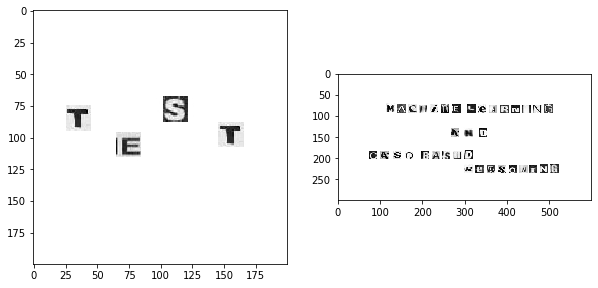

In [7]:
detection_1, detection_2 = load_detection_images()

plt.figure(figsize=(10, 8))
plt.subplot(1,2,1)
plt.imshow(detection_1, cmap="gray")

plt.subplot(1,2,2)
plt.imshow(detection_2, cmap="gray")


In [8]:
class DetectionVariables:
    def __init__(self):
        self.char_coordinates = []
        self.corresponding_letters = []
        self.corresponding_probabilities = []
        
def pre_process_window(window):
    #normalize pixels in image
    window = window = window / np.linalg.norm(window)
    #create hog of window
    window = feature.hog(window, pixels_per_cell=(2,2), cells_per_block=(1,1))
    #flatten image
    window = window.flatten()
    #put window in input array
    window = np.array([window])
    return window

def char_allready_found(dv, i, j, l, prob):
    for index in range(len(dv.char_coordinates)):
        c_i, c_j = dv.char_coordinates[index]
        if abs(c_i - i) < 30 and abs(c_j - j) < 30:
            if dv.corresponding_probabilities[index] < prob:
                dv.corresponding_probabilities[index] = prob
                dv.char_coordinates[index] = [i, j]
                dv.corresponding_letters[index] = l
            return True
    return False

def detect_objects(img):
    """
    Finds the letters in the images and puts them and their images in dictionary
    """
    #size of window
    window_size = 20
    
    #indices were letters start
    dv = DetectionVariables()
    
    img_H, img_W = img.shape
    #iterate over widht and height of image
    for i in range(0, img_H - window_size):
        for j in range(0, img_W - window_size):
            #create window of size of images that we classify
            window = img[i:i+window_size, j:j+window_size]
            window = pre_process_window(window)
            #predict character of window
            prediction = nn.predict_proba(window)
            if np.max(prediction) > 0.999:
                l = get_label(np.argmax(prediction))
                if not char_allready_found(dv, i, j, l, np.max(prediction)):
                    dv.char_coordinates.append([i,j])
                    dv.corresponding_letters.append(l)
                    dv.corresponding_probabilities.append(np.max(prediction))
                                                   
    return dv.char_coordinates

    

In [9]:
def draw_rectangles_around_letters(img, letter_coordinates):
    """
    params:
    img: 2D numpy array image
    letter_coordinates: list of coordinates for objects found
    returns:
    a copy of the image with boxes around letters
    """
    img = np.copy(img)
    #iterate over letters found
    for coord in letter_coordinates:
        #iterate iver coordinates where the letters were found
        i = coord[0]
        j = coord[1]
        #create border around letter
        border = img[i:i+20, j:j+20]
        border = np.pad(border, ((2,2),(2,2)), 'constant')
        img[i-2:i+22, j-2:j+22] = border

    return img


t


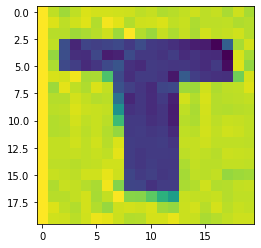

In [10]:
"""
example of taking a window from the image and performing classification on it
"""
window = detection_1[75:95, 25:45]
plt.imshow(window)
window = feature.hog(window, pixels_per_cell=(2,2), cells_per_block=(1,1))
window = window.flatten()
window = window = window / np.linalg.norm(window)
window = np.array([window])
l = nn.predict(window)
print(get_label(l[0]))


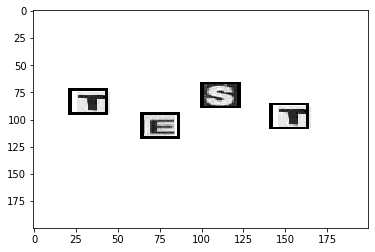

In [11]:
#detect objects on first image
img_1_objects = detect_objects(detection_1)
img_1 = draw_rectangles_around_letters(detection_1, img_1_objects)
plt.imshow(img_1, cmap="gray", aspect="auto")

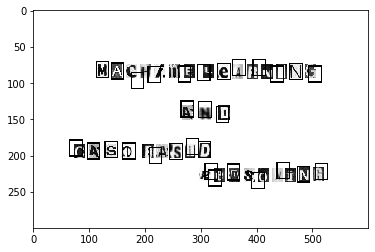

In [12]:
#detect objects on second image
img_2_objects = detect_objects(detection_2)
img_2 = draw_rectangles_around_letters(detection_2, img_2_objects)
plt.imshow(img_2, cmap="gray", aspect="auto")
